# Deep Learning for Mortgage Dataset

## Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import keras
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense, GRU, LSTM, Bidirectional
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Importing Mortgage Dataset
 

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  ##D:\Course\Drexel\Term 4 - Summer 2022\MGMT 715 - Business Consulting\Final Report\R

Saving loan_mg.csv to loan_mg.csv
User uploaded file "loan_mg.csv" with length 1759424 bytes


In [3]:
mg = pd.read_csv('loan_mg.csv')

### Data Exploration

In [4]:
mg.head()

,Unnamed: 0,MID,time,origin_time,maturity_time,RE_Type,investor,balance_orig_time,FICO_orig_time,LTV_orig_time,...,avg_balance,sd_balance,avg_interest_rate,sd_interest_rate,avg_hpi,sd_hpi,avg_gdp,sd_gdp,avg_uer,sd_uer
0,222,222,21,19,132,PU,0,161500.0,560,95.0,...,159444.466667,330.521337,8.600,0.0,199.830000,8.736515,3.324249,0.244217,5.333333,0.152753
1,223,223,51,19,135,OTH,0,73000.0,621,80.2,...,65290.726364,3706.885060,6.550,0.0,181.036061,29.116551,1.410750,2.064555,6.930303,2.095305
2,226,226,26,24,141,SF,0,290500.0,516,70.0,...,289699.963333,326.260287,10.200,0.0,225.046667,1.270840,2.723899,0.508108,4.700000,0.000000
3,227,227,30,23,141,OTH,0,269400.0,657,70.0,...,265750.832500,2114.825258,5.801,0.0,221.151250,4.444459,2.339611,0.658420,4.662500,0.176777
4,229,229,25,23,141,OTH,0,166500.0,503,67.1,...,165870.250000,255.831227,8.675,0.0,223.983333,2.199303,3.002480,0.111824,4.800000,0.173205


In [4]:
mg.drop('Unnamed: 0', axis=1, inplace=True)
mg.head()

,MID,time,origin_time,maturity_time,RE_Type,investor,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,...,avg_balance,sd_balance,avg_interest_rate,sd_interest_rate,avg_hpi,sd_hpi,avg_gdp,sd_gdp,avg_uer,sd_uer
0,222,21,19,132,PU,0,161500.0,560,95.0,0.00,...,159444.466667,330.521337,8.600,0.0,199.830000,8.736515,3.324249,0.244217,5.333333,0.152753
1,223,51,19,135,OTH,0,73000.0,621,80.2,6.55,...,65290.726364,3706.885060,6.550,0.0,181.036061,29.116551,1.410750,2.064555,6.930303,2.095305
2,226,26,24,141,SF,0,290500.0,516,70.0,0.00,...,289699.963333,326.260287,10.200,0.0,225.046667,1.270840,2.723899,0.508108,4.700000,0.000000
3,227,30,23,141,OTH,0,269400.0,657,70.0,0.00,...,265750.832500,2114.825258,5.801,0.0,221.151250,4.444459,2.339611,0.658420,4.662500,0.176777
4,229,25,23,141,OTH,0,166500.0,503,67.1,0.00,...,165870.250000,255.831227,8.675,0.0,223.983333,2.199303,3.002480,0.111824,4.800000,0.173205


Viewing the structure of the dataset using `info()`.

In [6]:
mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8146 entries, 0 to 8145
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MID                      8146 non-null   int64  
 1   time                     8146 non-null   int64  
 2   origin_time              8146 non-null   int64  
 3   maturity_time            8146 non-null   int64  
 4   RE_Type                  8146 non-null   object 
 5   investor                 8146 non-null   int64  
 6   balance_orig_time        8146 non-null   float64
 7   FICO_orig_time           8146 non-null   int64  
 8   LTV_orig_time            8146 non-null   float64
 9   Interest_Rate_orig_time  8146 non-null   float64
 10  hpi_orig_time            8146 non-null   float64
 11  status_time              8146 non-null   int64  
 12  avg_LTV                  8146 non-null   float64
 13  sd_LTV                   8146 non-null   float64
 14  avg_balance             

Our aggregated dataset is made up of 24 variables and 8,146 unique entries.

## Data Preprocessing & Transformation

### Categorical Variables: One Hot Encoding

Evaluating for class imbalance in Target Variable.

Target Variable: Status Time

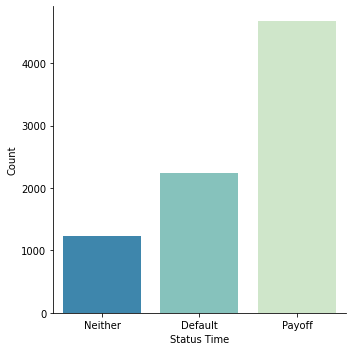

In [7]:
g = sns.catplot(x="status_time", 
            data=mg, kind='count', 
            palette='GnBu_r', legend=False) ###PuBuGn_r ###GnBu_r


(g.set_axis_labels("Status Time", "Count")
  .set_xticklabels(["Neither", "Default", "Payoff"]))  

####.despine(left=True)) 

We will correct for class imbalance during modelling

Status time has 3 classes, 0 = Neither, 1 = Default, 2 = Payoff

We can see there is class imbalance between the classes. 

Payoff is majority, Neither is minority and Default is less than half of Payoff

In [5]:
target_var = pd.get_dummies(mg.status_time).values  

## setting our Target variable as a variable

Investor and Real Estate Type are nominal variables. Investor is already binary. 

Real Estate Type has multiple classes. We will binarize using `get_dummies`.

In [6]:
mg = pd.get_dummies(mg, columns = ['RE_Type'], prefix = 'Real_Estate_Type', prefix_sep = '_')

In [10]:
mg.head()

,MID,time,origin_time,maturity_time,investor,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,...,avg_hpi,sd_hpi,avg_gdp,sd_gdp,avg_uer,sd_uer,Real_Estate_Type_CO,Real_Estate_Type_OTH,Real_Estate_Type_PU,Real_Estate_Type_SF
0,222,21,19,132,0,161500.0,560,95.0,0.00,191.42,...,199.830000,8.736515,3.324249,0.244217,5.333333,0.152753,0,0,1,0
1,223,51,19,135,0,73000.0,621,80.2,6.55,191.42,...,181.036061,29.116551,1.410750,2.064555,6.930303,2.095305,0,1,0,0
2,226,26,24,141,0,290500.0,516,70.0,0.00,223.75,...,225.046667,1.270840,2.723899,0.508108,4.700000,0.000000,0,0,0,1
3,227,30,23,141,0,269400.0,657,70.0,0.00,221.91,...,221.151250,4.444459,2.339611,0.658420,4.662500,0.176777,0,1,0,0
4,229,25,23,141,0,166500.0,503,67.1,0.00,221.91,...,223.983333,2.199303,3.002480,0.111824,4.800000,0.173205,0,1,0,0


## Standardization

We will apply min-max (range) normalization to the training data prior to modeling.

## Train/Test Split

Before creating our training and testing datasets, we need to isolate our predictor variables and the variable that we want to predict in the classification. 


We set the 'Status Time' column as our y variable, and name it 'y'.

'Status_Time' has been put in our *target_var* variable beforehand.

In [7]:
X = mg.drop(['MID', 'time', 'origin_time','status_time'], axis = 1)  
y = target_var


Creating a dataset split on *Train* and *Test*

In [8]:
x_train, x_test, y_train  , y_test = train_test_split(X, y, test_size = 0.3, random_state = 2527)

### Handling Class Imbalance

We will be using the Synthetic Minority Oversampling Technique (SMOTE) for Oversampling our Target Variable.

In [9]:
#pip install -U imbalanced-learn

In [10]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [11]:
# Oversampling using SMOTE
sm = SMOTE(random_state=2527)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)


## Source: https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037

Next, we will use `MinMaxScaler()` to apply range (min-max) normalization to the predictor variables in the training dataset. 

We will normalize the testing dataset later when evaluating model performance.

In [12]:
range_scaler = MinMaxScaler()
range_scaler.fit(x_train_sm)
norm_x_train_sm= range_scaler.transform(x_train_sm)

## Deep Learning Networks

### Basic Neural Network Model

Creating a Sequential model using Sequential() and add configured layers using add().

In [13]:
nn_mod = Sequential()

### Dense Hidden Layers

- Dense Layers: 5 
- Activation Function: Rectified Linear Unit (`relu`)
- Units: 128, 64, 32, 16, 8

In [14]:
nn_mod.add(Dense(units = 128,
              activation = 'relu',
              name = 'Hidden_Layer_1'))

In [15]:
nn_mod.add(Dense(units = 64,
              activation = 'relu',
              name = 'Hidden_Layer_2'))

In [16]:
nn_mod.add(Dense(units = 32,
              activation = 'relu',
              name = 'Hidden_Layer_3'))

In [17]:
nn_mod.add(Dense(units = 16,
              activation = 'relu',
              name = 'Hidden_Layer_4'))

In [18]:
nn_mod.add(Dense(units = 8,
              activation = 'relu',
              name = 'Hidden_Layer_5'))

### Dense Output Layer

Since we have multiclass *Target Variable*, we would use `softmax` for for the activation function of the output layer.

In [19]:
nn_mod.add(Dense(units = 3,
              activation = 'softmax',
              name = 'Output_Layer'))

### Evaluating the Model


- Loss Function: Categorical crossentropy  (`loss = categorical_crossentropy`)
  
- Optimizer: Adam (adjusts the weights throughout the neural network as it learns)

- Performance Metrics:  categorical accuracy (`metrics = categorical_accuracy`) 

In [20]:
nn_mod.compile(loss = 'categorical_crossentropy', 
            optimizer = 'adam',
            metrics = 'categorical_accuracy')

#### Model Training

For model training, we will specify the batch size, number of epochs and size of the validation set.

- **Batch Size**: 32
- **Epochs**: 20
- **Validation Split**: 10%


In [21]:
nn_mod_fit = nn_mod.fit(norm_x_train_sm, y_train_sm, batch_size = 32, 
                        validation_split = 0.1, 
                        epochs = 20)

Epoch 1/20
274/274 [==============================] - 2s 4ms/step - loss: 0.7587 - categorical_accuracy: 0.6755 - val_loss: 1.0077 - val_categorical_accuracy: 0.4275
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5383 - categorical_accuracy: 0.7839 - val_loss: 0.6086 - val_categorical_accuracy: 0.7420
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4668 - categorical_accuracy: 0.8102 - val_loss: 0.6512 - val_categorical_accuracy: 0.7225
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4353 - categorical_accuracy: 0.8238 - val_loss: 0.6618 - val_categorical_accuracy: 0.6968
Epoch 5/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4255 - categorical_accuracy: 0.8240 - val_loss: 0.4638 - val_categorical_accuracy: 0.7862
Epoch 6/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4162 - categorical_accuracy: 0.8303 - val_loss: 0.4790 - val_categorical_accuracy: 0.7965
Epoc

We use `evaluate()` to obtain the accuracy of our model on our full training dataset.

In [22]:
nn_mod.evaluate(norm_x_train_sm, y_train_sm)

305/305 [==============================] - 0s 1ms/step - loss: 0.3374 - categorical_accuracy: 0.8634


[0.33741527795791626, 0.8633980751037598]

In [23]:
history_dict = nn_mod_fit.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

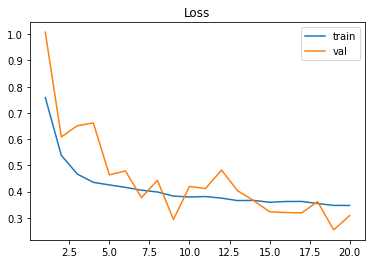

In [24]:
epochs = range(1, len(history_dict['loss']) + 1)
plt.title('Loss')
plt.plot(epochs, history_dict['loss'], label='train')
plt.plot(epochs, history_dict['val_loss'], label='val')
plt.legend()
plt.show();

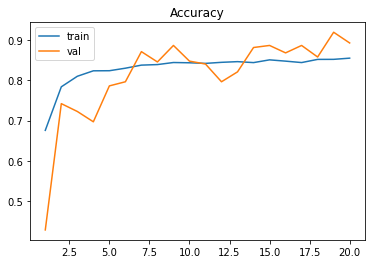

In [25]:
plt.title('Accuracy')
plt.plot(epochs, history_dict['categorical_accuracy'], label='train')
plt.plot(epochs, history_dict['val_categorical_accuracy'], label='val')
plt.legend()
plt.show();

We can use the above plots for evaluating the model. We can see that the model runs differently on training and validation dataset.

##### (Using `dropout()` did not help mitigate the issue)

Obtaining training performance information. 

In [26]:
preds_train_sm = (nn_mod.predict(norm_x_train_sm) > 0.5).astype("int32")

In [27]:
print(classification_report(y_train_sm, preds_train_sm, digits= 4))

              precision    recall  f1-score   support

           0     0.9465    0.9756    0.9608      3243
           1     0.8317    0.7922    0.8114      3243
           2     0.8154    0.8147    0.8151      3243

   micro avg     0.8659    0.8608    0.8634      9729
   macro avg     0.8645    0.8608    0.8624      9729
weighted avg     0.8645    0.8608    0.8624      9729
 samples avg     0.8608    0.8608    0.8608      9729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Visualizing the Network Architecture

In [28]:
nn_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 128)               3072      
                                                                 
 Hidden_Layer_2 (Dense)      (None, 64)                8256      
                                                                 
 Hidden_Layer_3 (Dense)      (None, 32)                2080      
                                                                 
 Hidden_Layer_4 (Dense)      (None, 16)                528       
                                                                 
 Hidden_Layer_5 (Dense)      (None, 8)                 136       
                                                                 
 Output_Layer (Dense)        (None, 3)                 27        
                                                                 
Total params: 14,099
Trainable params: 14,099
Non-traina

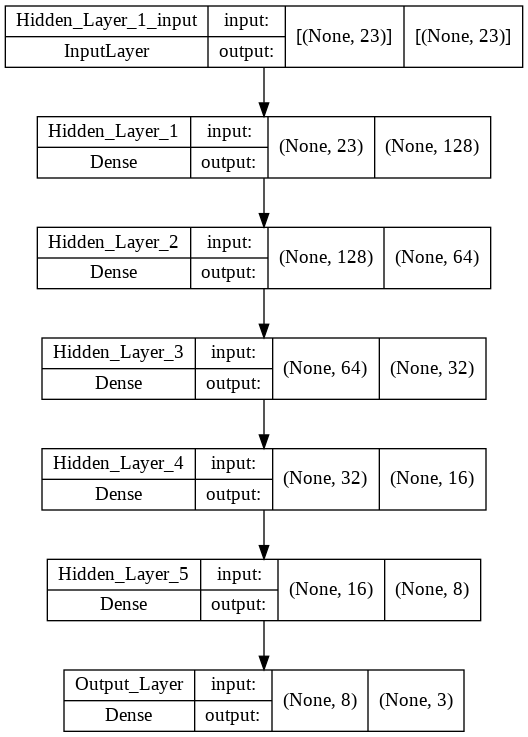

In [29]:
plot_model(nn_mod, show_shapes=True, show_layer_names=True)

#### Model Testing

Obtaining Testing performance information using range normalize input variables.

In [30]:
norm_x_test = range_scaler.transform(x_test)

In [31]:
preds_test = (nn_mod.predict(norm_x_test) > 0.5).astype("int32")
print(classification_report(y_test, preds_test, digits= 4))

              precision    recall  f1-score   support

           0     0.8429    0.9620    0.8985       368
           1     0.6369    0.6776    0.6566       642
           2     0.8514    0.7789    0.8135      1434

   micro avg     0.7892    0.7799    0.7845      2444
   macro avg     0.7770    0.8062    0.7895      2444
weighted avg     0.7938    0.7799    0.7851      2444
 samples avg     0.7799    0.7799    0.7799      2444



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Tuning


### Keras Tuner

install and import keras tuner. 

In [32]:
pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 4.0 MB/s 
     |████████████████████████████████| 1.6 MB 37.6 MB/s 


In [33]:
import keras_tuner as kt

Using `hp.Int()` to create a sequence for our grid search 

In [34]:
def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value 
  hp_units1 = hp.Int('units_1', min_value = 16, 
                     max_value = 128, 
                     step = 16)
  hp_units2 = hp.Int('units_2', min_value = 16, 
                     max_value = 64, 
                     step = 16)
  hp_units3 = hp.Int('units_3', min_value = 16, 
                     max_value = 64, 
                     step = 8)
  hp_units4 = hp.Int('units_4', min_value = 16, 
                     max_value = 32, 
                     step = 8)
  hp_units5 = hp.Int('units_5', min_value = 8, 
                     max_value = 32, 
                     step = 8)
  model.add(Dense(units = hp_units1, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units2, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units3, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units4, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units5, 
                               activation = 'relu'))
  model.add(Dense(units = 3,
              activation = 'softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.1 - 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4])

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = 'categorical_crossentropy',
                metrics = 'categorical_accuracy')

  return model

In [35]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_categorical_accuracy',
                     max_epochs = 20,
                     factor = 3,
                     seed = 2527,
                     directory = 'my_dir',
                     project_name = 'DL_KT_MTG')

Using `EarlyStopping()` to choose a good number for the number of epochs and avoid overfitting the model by seeking to optimize `val_loss`.

In [36]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 3)

Conducting the hyperparameter search using `search()` and obtaining the value of the highest validation accuracy.

In [37]:
tuner.search(norm_x_train_sm, 
             y_train_sm, 
             epochs = 20, 
             batch_size = 32, 
             validation_split = 0.1, 
             callbacks = [stop_early])

Trial 30 Complete [00h 00m 04s]
val_categorical_accuracy: 0.0030832476913928986

Best val_categorical_accuracy So Far: 0.9003083109855652
Total elapsed time: 00h 03m 23s


Getting the values of our optimal hyperparameters.

In [38]:
best_mod = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_mod.get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'units_1',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 128,
    'step': 16,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_2',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 64,
    'step': 16,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_3',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 64,
    'step': 8,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_4',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 32,
    'step': 8,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_5',
    'default': None,
    'conditions': [],
    'min_value': 8,
    'max_value': 32,
    'step': 8,
    'sampling': None}},
  {'class_name': 'Choice',
   'config': {'name': 'learning_rate',
    'default': 0.1

Running the model using our optimal hyperparameters.

In [39]:
model_tune = tuner.hypermodel.build(best_mod)
history_tune = model_tune.fit(norm_x_train_sm, 
                              y_train_sm,
                              epochs = best_mod.get('tuner/epochs'),
                              batch_size = 32,
                              validation_split = 0.1)

Epoch 1/20
274/274 [==============================] - 2s 4ms/step - loss: 0.6859 - categorical_accuracy: 0.7117 - val_loss: 0.6540 - val_categorical_accuracy: 0.7338
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5268 - categorical_accuracy: 0.7855 - val_loss: 0.5088 - val_categorical_accuracy: 0.8068
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4861 - categorical_accuracy: 0.8034 - val_loss: 0.8116 - val_categorical_accuracy: 0.6876
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4681 - categorical_accuracy: 0.8101 - val_loss: 0.7765 - val_categorical_accuracy: 0.6732
Epoch 5/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4419 - categorical_accuracy: 0.8176 - val_loss: 0.6696 - val_categorical_accuracy: 0.7420
Epoch 6/20
274/274 [==============================] - 1s 3ms/step - loss: 0.4414 - categorical_accuracy: 0.8230 - val_loss: 0.3233 - val_categorical_accuracy: 0.8684
Epoc

In [40]:
preds_train_tune = (model_tune.predict(norm_x_train_sm) > 0.5).astype("int32")
print(classification_report(y_train_sm, preds_train_tune, digits = 4))

              precision    recall  f1-score   support

           0     0.8870    0.9806    0.9315      3243
           1     0.8221    0.6713    0.7391      3243
           2     0.7761    0.8208    0.7978      3243

   micro avg     0.8299    0.8242    0.8270      9729
   macro avg     0.8284    0.8242    0.8228      9729
weighted avg     0.8284    0.8242    0.8228      9729
 samples avg     0.8242    0.8242    0.8242      9729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
preds_test_tune = (model_tune.predict(norm_x_test) > 0.5).astype("int32")
print(classification_report(y_test, preds_test_tune, digits = 4))

              precision    recall  f1-score   support

           0     0.8207    0.9701    0.8892       368
           1     0.6474    0.6293    0.6382       642
           2     0.8336    0.7929    0.8127      1434

   micro avg     0.7833    0.7766    0.7799      2444
   macro avg     0.7672    0.7974    0.7800      2444
weighted avg     0.7827    0.7766    0.7784      2444
 samples avg     0.7766    0.7766    0.7766      2444



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**---------END---------**

